In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as tt

from bokeh.plotting import figure, show
from bokeh.models import BoxAnnotation, Span, Label, Legend
from bokeh.io import output_notebook
from bokeh.palettes import brewer
output_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [2]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    date = pd.to_datetime(date)
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [3]:
ice = pd.read_csv(pm.get_data("merged_ice_core_yearly.csv"), header=26)
ice.columns = ["year", "CO2"]
ice["CO2"] = ice["CO2"].astype(np.float)

#### DATA AFTER 1958 is an average of ice core and mauna loa data, so remove it
ice = ice[ice["year"] <= 1958]
print("Number of data points:", len(ice))

Number of data points: 111


In [4]:
airdata = pd.read_csv(pm.get_data("monthly_in_situ_co2_mlo.csv"), header=56)

# - replace -99.99 with NaN
airdata.replace(to_replace=-99.99, value=np.nan, inplace=True)

# fix column names
cols = ["year", "month", "--", "--", "CO2", "seasonaly_adjusted", "fit",
        "seasonally_adjusted_fit", "CO2_filled", "seasonally_adjusted_filled"]
airdata.columns = cols
cols.remove("--"); cols.remove("--")
airdata = airdata[cols]

# drop rows with nan
airdata.dropna(inplace=True)

# fix time index
airdata["day"] = 15
airdata.index = pd.to_datetime(airdata[["year", "month", "day"]])
airdata["year"] = [toYearFraction(date) for date in airdata.index.values]
cols.remove("month")
airdata = airdata[cols]

air = airdata[["year", "CO2"]]
air.head(5)

,year,CO2
1958-03-15,1958.200000,315.69
1958-04-15,1958.284932,317.46
1958-05-15,1958.367009,317.50
1958-07-15,1958.534132,315.86
1958-08-15,1958.619064,314.93


In [5]:
sep_idx = air.index.searchsorted(pd.to_datetime("2003-12-15"))
air_test = air.iloc[sep_idx:, :]
air = air.iloc[:sep_idx+1, :]

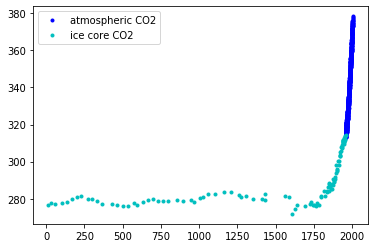

In [6]:
plt.plot(air.year.values, air.CO2.values, ".b", label="atmospheric CO2");
plt.plot(ice.year.values, ice.CO2.values, ".", color="c", label="ice core CO2");
plt.legend();

In [7]:
class CustomWhiteNoise(pm.gp.cov.Covariance):
    """ Custom White Noise covariance
    - sigma1 is applied to the first n1 points in the data
    - sigma2 is applied to the next n2 points in the data

    The total number of data points n = n1 + n2
    """
    def __init__(self, sigma1, sigma2, n1, n2):
        super(CustomWhiteNoise, self).__init__(1, None)
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.n1 = n1
        self.n2 = n2

    def diag(self, X):
        d1 = tt.alloc(tt.square(self.sigma1), self.n1)
        d2 = tt.alloc(tt.square(self.sigma2), self.n2)
        return tt.concatenate((d1, d2), 0)

    def full(self, X, Xs=None):
        if Xs is None:
            return tt.diag(self.diag(X))
        else:
            return tt.alloc(0.0, X.shape[0], Xs.shape[0])

In [8]:
# form dataset, stack t and co2 measurements
t = np.concatenate((ice.year.values, air.year.values), 0)
y = np.concatenate((ice.CO2.values, air.CO2.values), 0)

y_mu, y_sd = np.mean(ice.CO2.values[0:50]), np.std(y)
y_n = (y - y_mu) / y_sd
t_n = t * 0.01

In [9]:
def logistic(x, a, x0):
    # a is the slope, x0 is the location
    return pm.math.invlogit(a*(x - x0))

In [10]:
with pm.Model() as model:
    ηc = pm.Gamma("ηc", alpha=3, beta=2)
    ℓc = pm.Gamma("ℓc", alpha=10, beta=1)

    # changepoint occurs near the year 1800, sometime between 1760, 1840
    x0 = pm.Normal("x0", mu=18, sd=0.1)
    # the change happens gradually
    a = pm.Gamma("a", alpha=3, beta=1)
    # constant offset
    c = pm.HalfNormal("c", sd=2)

    # quadratic polynomial scale
    ηq = pm.HalfNormal("ηq", sd=1)
    ℓq = 2.0 # 2 century impact, since we only have 2 C of post IR data 

    cov1 = ηc**2 * pm.gp.cov.ExpQuad(1, ℓc)
    cov2 = ηc**2 * pm.gp.cov.ExpQuad(1, ℓc) + \
           ηq**2 * pm.gp.cov.Polynomial(1, x0, 2, c) * pm.gp.cov.Matern52(1, ℓq) # ~2 century impact

    # construct changepoint cov
    sc_cov1 = pm.gp.cov.ScaledCov(1, cov1, logistic, (-a, x0))
    sc_cov2 = pm.gp.cov.ScaledCov(1, cov2, logistic, ( a, x0))
    gp_c = pm.gp.Marginal(cov_func=sc_cov1 + sc_cov2)

    # short term variation
    ηs = pm.HalfNormal("ηs", sd=3)
    ℓs = pm.Gamma("ℓs", alpha=5, beta=100)
    α = pm.Gamma("α", alpha=4, beta=1)
    cov_s = ηs**2 * pm.gp.cov.RatQuad(1, α, ℓs)
    gp_s = pm.gp.Marginal(cov_func=cov_s)

    # medium term variation
    ηm = pm.HalfNormal("ηm", sd=5)
    ℓm = pm.Gamma("ℓm", alpha=2, beta=3)
    cov_m = ηm**2 * pm.gp.cov.ExpQuad(1, ℓm)
    gp_m = pm.gp.Marginal(cov_func=cov_m)

    ## periodic
    ηp = pm.HalfNormal("ηp", sd=2)
    ℓp_decay = pm.Gamma("ℓp_decay", alpha=40, beta=0.1)
    ℓp_smooth = pm.Normal("ℓp_smooth ", mu=1.0, sd=0.05)
    period = 1 * 0.01  # we know the period is annual
    cov_p = ηp**2 * pm.gp.cov.Periodic(1, period, ℓp_smooth) \
                  * pm.gp.cov.ExpQuad(1, ℓp_decay)
    gp_p = pm.gp.Marginal(cov_func=cov_p) 

    gp = gp_c + gp_m + gp_s + gp_p

    # - x location uncertainty (sd = 0.01 is a standard deviation of one year)
    # - only the first 111 points are the ice core data
    # - sd = 0.002 says the point may be the given data +- about half a year
    t_mu = t_n[:111]
    t_diff = pm.Normal("t_diff", mu=0.0, sd=0.002, shape=len(t_mu))
    t_uncert = t_mu - t_diff
    t_combined = tt.concatenate((t_uncert, t_n[111:]), 0)

    # Noise covariance, using boundary avoiding priors for MAP estimation
    σ1 = pm.Gamma("σ1", alpha=3, beta=50)
    σ2 = pm.Gamma("σ2", alpha=3, beta=50)
    η_noise = pm.HalfNormal("η_noise", sd=1)
    ℓ_noise = pm.Gamma("ℓ_noise", alpha=2, beta=200)
    cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise) +\
                CustomWhiteNoise(σ1, σ2, 111, 545)


    y_ = gp.marginal_likelihood("y", X=t_combined[:,None], y=y_n, noise=cov_noise)

/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/pymc3/gp/cov.py:93: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)
/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/pymc3/gp/cov.py:93: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)
/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/pymc3/gp/cov.py:93: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to u

In [17]:
t_mu = t_n[:111]
#t_diff = pm.Normal("t_diff", mu=0.0, sd=0.002, shape=len(t_mu))
#t_uncert = t_mu - t_diff
#t_combined = tt.concatenate((t_uncert, t_n[111:]), 0)
#t_combined
y_n

array([-8.59387985e-02, -4.26861518e-02, -6.18244911e-02, -5.68485229e-02,
       -3.31169822e-02,  4.03742405e-02,  6.60196151e-02,  9.54926575e-02,
        4.34363747e-02,  3.19533712e-02, -2.87840622e-03, -7.44557950e-02,
       -7.98145300e-02, -8.70870989e-02, -1.00866703e-01, -1.14646307e-01,
       -5.49346890e-02, -8.01972968e-02, -2.85237808e-02,  1.51116327e-02,
        2.69774030e-02, -1.78063108e-02, -1.78063108e-02, -1.70407773e-02,
        1.31977987e-02, -3.26117301e-03,  4.77692948e-03, -2.04856783e-02,
        5.75987458e-02,  7.02300497e-02,  1.44104039e-01,  1.43721272e-01,
        1.86973919e-01,  1.76256449e-01,  1.19224198e-01,  8.17130532e-02,
        9.58754243e-02,  4.07570073e-02,  2.39152687e-02,  2.08531344e-02,
        1.34917636e-01,  1.05444594e-01,  7.78853854e-02, -2.74260057e-01,
       -1.72061325e-01, -9.09147667e-02, -1.05077138e-01, -7.86662296e-02,
       -2.92893144e-02, -8.63215653e-02, -9.97184028e-02, -1.02397770e-01,
       -4.65138197e-02, -

In [11]:
with model:
    mp = pm.find_MAP(method="BFGS")

/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[

/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [12]:
tnew = np.linspace(1700, 2040, 3000) * 0.01
mu, var = gp.predict(tnew[:,None], point=mp, diag=True)

/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/pymc3/gp/cov.py:93: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)
/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/pymc3/gp/cov.py:93: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter 

In [13]:
# rescale
mu_s = y_sd * mu + y_mu
sd = np.sqrt(var)*y_sd

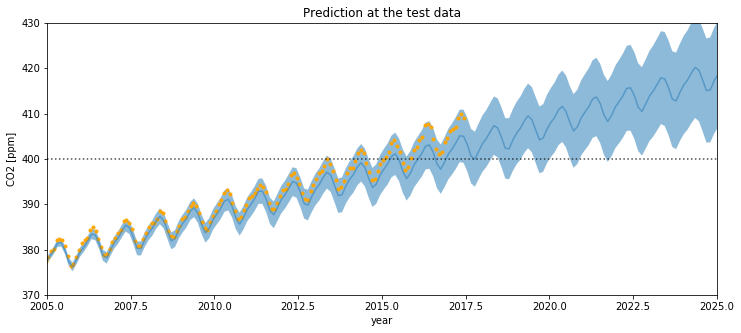

In [14]:
plt.figure(figsize=(12,5))

plt.plot(t, y, 'k.');
plt.plot(100*(t_n[:111] - mp["t_diff"]), y[:111], ".y");
plt.plot(air_test.year.values, air_test.CO2.values, ".", color="orange");

plt.plot(100*tnew, mu_s, alpha=0.5);
plt.fill_between(100*tnew, mu_s - 2*sd, mu_s + 2*sd, alpha=0.5);
plt.axhline(y=400, color="k", alpha=0.7, linestyle=":")
plt.ylabel("CO2 [ppm]")
plt.xlabel("year")
plt.title("Prediction at the test data")
plt.xlim([2005,2025]);
plt.ylim([370, 430]);